# DSCI 100 Final Project - Heart Disease Classification

DSCI 100 002 Group 10

Group Members: Lily Xie, Eric Ai, William Wang

# Temporary Housekeeping Checklist (To be Removed at the end)



### Feedback and comment on the project proposal
* Lack of explanations of summary table and graphs. What do you hope readers will gleam from looking at your graphs? Providing commentary on tables/graphs would be a great way of supporting your use of predictors.


### General checklist
1. Include reference and explaination in why we choose the three predictors ("You should have some sort of further evidence to back this up. This should be done with either outside sources or your visualizations.")




* Don't forget to check code format after we finish everything (eg. space, pipe operator, etc.)
* make sure we clean it at the end and only include relevant information and graphs!
* can also add a reference for the discussion - impact part. eg. previous examples of using medical analysis to prevent heart diseases.



## Group Project Requirements (TBD)

just for an easy reference
https://canvas.ubc.ca/courses/83542/assignments/1106464

# Introduction

Heart disease is consistently rated as the top 1 cause of death around the world over the last two decades. A lot of factors may or may not have an effect on the presence of heart disease, and our group is interested in exploring the possible factors of heart disease via relevant dataset(s). In the data analysis we are about to perform, we plan to select some of the possible correlated factors to heart disease according to possible relevance, and assess how well the chosen predictors can predict heart disease using knn-classification.

Heart disease is a general term that describes several types of heart conditions. Before we begin, we would like to briefly explain the dataset we chose. The data set we plan to use is processed.cleveland.data; it is collected from individuals residing in Cleveland, USA. In this dataset, heart disease is shown as the percentage narrowing of blood vessels. A value 0 indicates < 50% diameter narrowing and no presence of heart disease, and a value >=1 indicates > 50% diameter narrowing as well as the presence of heart disease.

Our dataset also contains the following 13 variables as potential predictors: age, sex, types of chest pain (cp), resting blood pressure (trestbps), cholesterol level (chol), fasting blood sugar (fbs), resting electrocardiographic measurement (restecg), max heart rate (thalach), trigger (exang, exercise=1, other= 0), exercise-induced depression (oldpeak), the slope of the peak exercise ST segment (slope), number of vessels colored by fluoroscopy (ca, ranges from 0-3), thal (3 = normal; 6 = fixed defect; 7 = reversable defect). All of the above factors may or may not affect the chance of having heart disease.

During the method section, we determined our predictors - age and thalach using density graphs created from our dataset(figure 1.1), the explanation and reasoning are under Methods & Results.

Therefore, our main question for this study is: 

<b> How well do age and thalach together predict heart disease in Cleveland? </b>

To answer this question, we will be performing data analysis in the heart disease dataset as shown below. 


# Methods & Results

In [2]:
options(repr.matrix.max.rows = 20)
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr) 
options(repr.matrix.max.rows = 8)

set.seed(2022)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

As we download the file processed_cleveland.data and opened it in a text editor, we can see that all the variables for observations are separated by commas. We can go ahead and read in the dataset using read_csv, and call cleveland_data_raw to see what the dataset looks like.

In [3]:
set.seed(2022)
cleveland_data_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
cleveland_data_raw

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


As shown on the table, the data set follows the criterion for tidy data: each variable forms a column, each observation forms a row, and each cell is a single measurement. The only element missing is the column titles, and we can manually assign them according to the data description on the web.


In [4]:
set.seed(2022)
cleveland_data = cleveland_data_raw %>%
                 rename (age = X1, sex = X2, cp= X3, trestbps = X4, 
                         chol = X5, fbs = X6, restecg = X7, thalach = X8,
                         exang = X9, oldpeak = X10, slope = X11, ca = X12,
                         thal = X13, num = X14)
cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Table1.1 Cleveland Heart Disease Data Frame with Coresponding Column Names

Just for clarification, here are what all the column names representing:

<blockquote>
1. age: age in years
    
2. sex: sex (1 = male; 0 = female)
    
3. cp: chest pain type
       -- Value 1: typical angina
       -- Value 2: atypical angina
       -- Value 3: non-anginal pain
       -- Value 4: asymptomatic
    
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl, (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
       -- Value 0: normal
       -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
       -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
       -- Value 1: upsloping
       -- Value 2: flat
       -- Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status)
       -- Value 0: < 50% diameter narrowing
       -- Value 1: > 50% diameter narrowing

Note that "num" is also the predicted attribute in our data analysis.

To better perform the data analysis, we need to wrangle the data a bit more. As mentioned in the description of the data set, there are only 2 distinct levels in blood vessel narrowing levels:  Value 0 indicates < 50% diameter narrowing, and Value 1 indicates > 50% diameter narrowing. Therefore , we converted num values >=1 all into 1 and values of 0 all into 0 (because if we keep 0 as no heart disease, it creates trouble in later data analysis). so that there are only two classes: 0 = no heart disease, 1 = have heart disease.We converted all character variables into numeric so that they can be used appropriately in our preliminary exploratory data analysis (density graphing). We also converted the category “num” (which is what we are trying to predict) into a factor, so that it can be used in our knn-classification algorithm. 

In [20]:
set.seed(2022)
# Cleaning and wrangling

# Turning 1 2 3 4 into 1 
cleveland_data_clean = mutate(cleveland_data, num = ifelse(num >= 1 , 1, 0) )%>%

# Removing row with missing value 
 filter_all(all_vars(!(. %in% c('?'))))%>%

# Changing num into a factor and change chracter data type into numeric data type for later analysis
mutate(num= as_factor(num))

cleveland_data_clean

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,1
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


table1.2 Cleveland data after cleaning  <blockquote>Quick Note: In column "num", 1 is with heart disease, 0 is without.</blockquote> 

### Splitting for Training and Testing Sets


First, we split the data into 75% training set and 25% testing set. The variable to predict is num, which tells us if they have heart disease or not (0=no heart disease, 1=heart disease).

In [16]:
set.seed(2022)
#Splitting the dataset into training and testing sets
cleveland_split <- initial_split(cleveland_data_clean, prop = 0.75, strata = num)  
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

### Training Data Predictor Data Plot

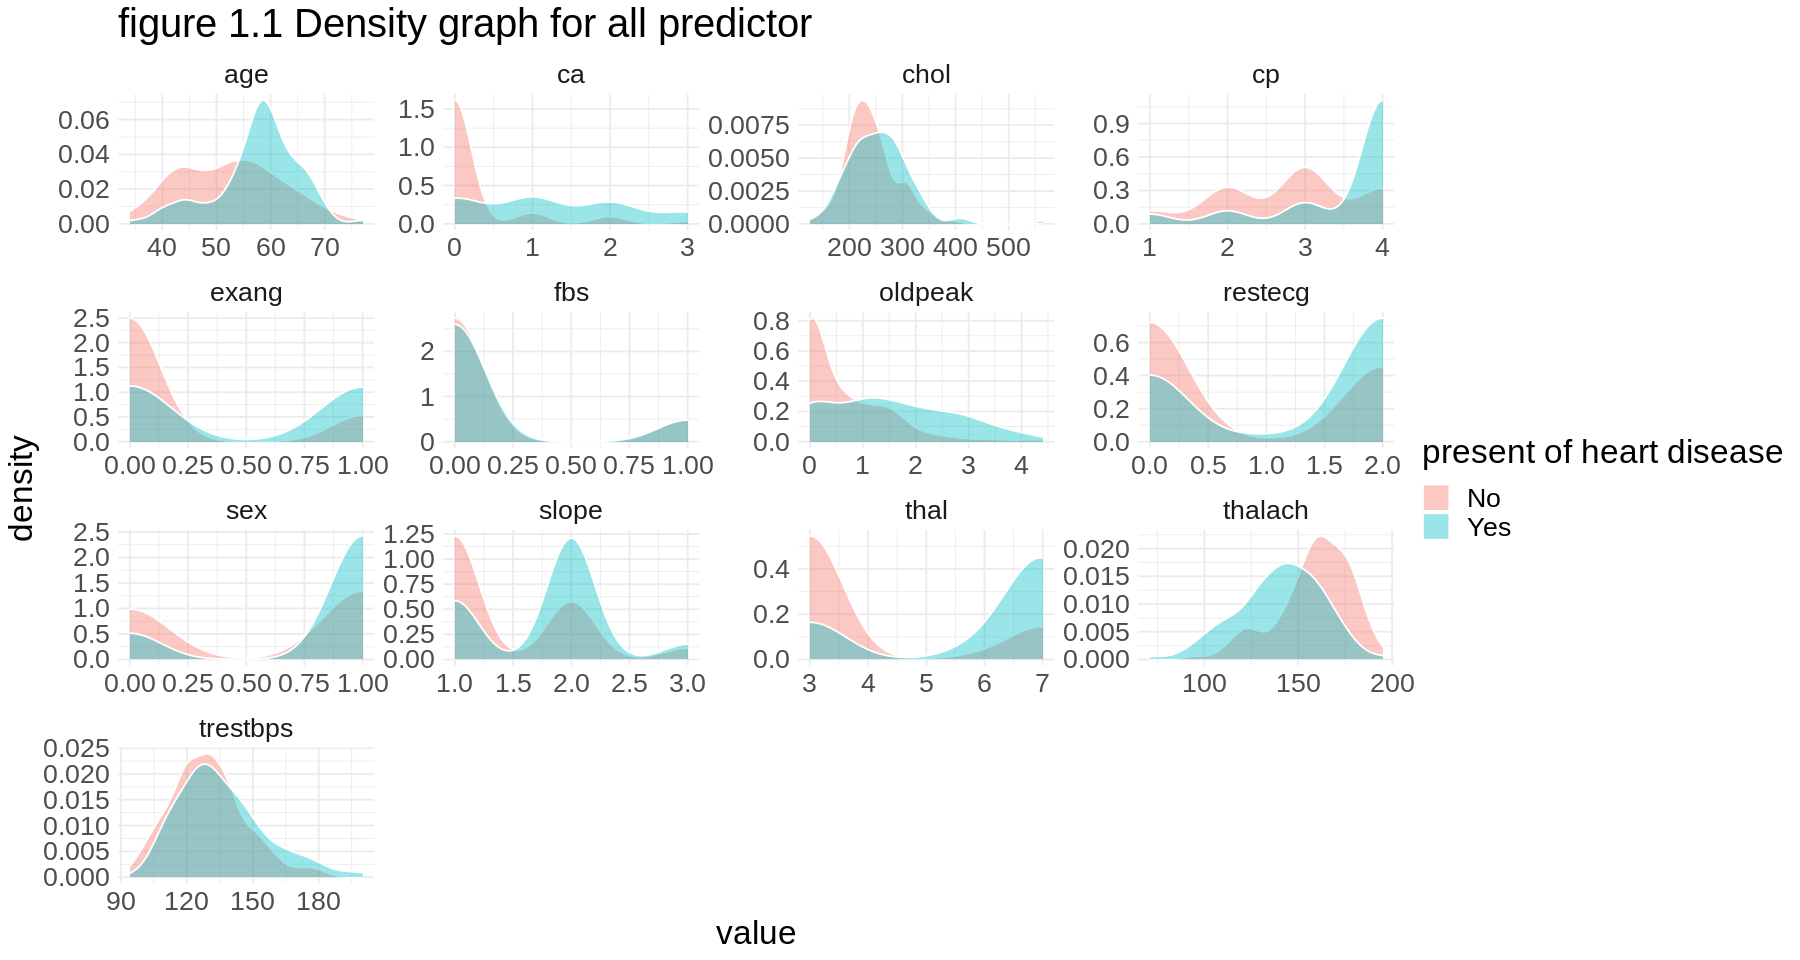

In [7]:
set.seed(2022)
cleveland_data_training_mutate= cleveland_training %>%
mutate(ca = as.numeric(ca), thal = as.numeric(thal))

options(repr.plot.height = 8, repr.plot.width = 15)
cleveland_data_training_mutate %>%
    pivot_longer(cols = -num, names_to = 'category', values_to = 'value')  %>% 
    ggplot(aes(value, fill = num)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))+
scale_fill_discrete(name='present of heart disease',labels=c("No", "Yes"))+
ggtitle("figure 1.1 Density graph for all predictor ")

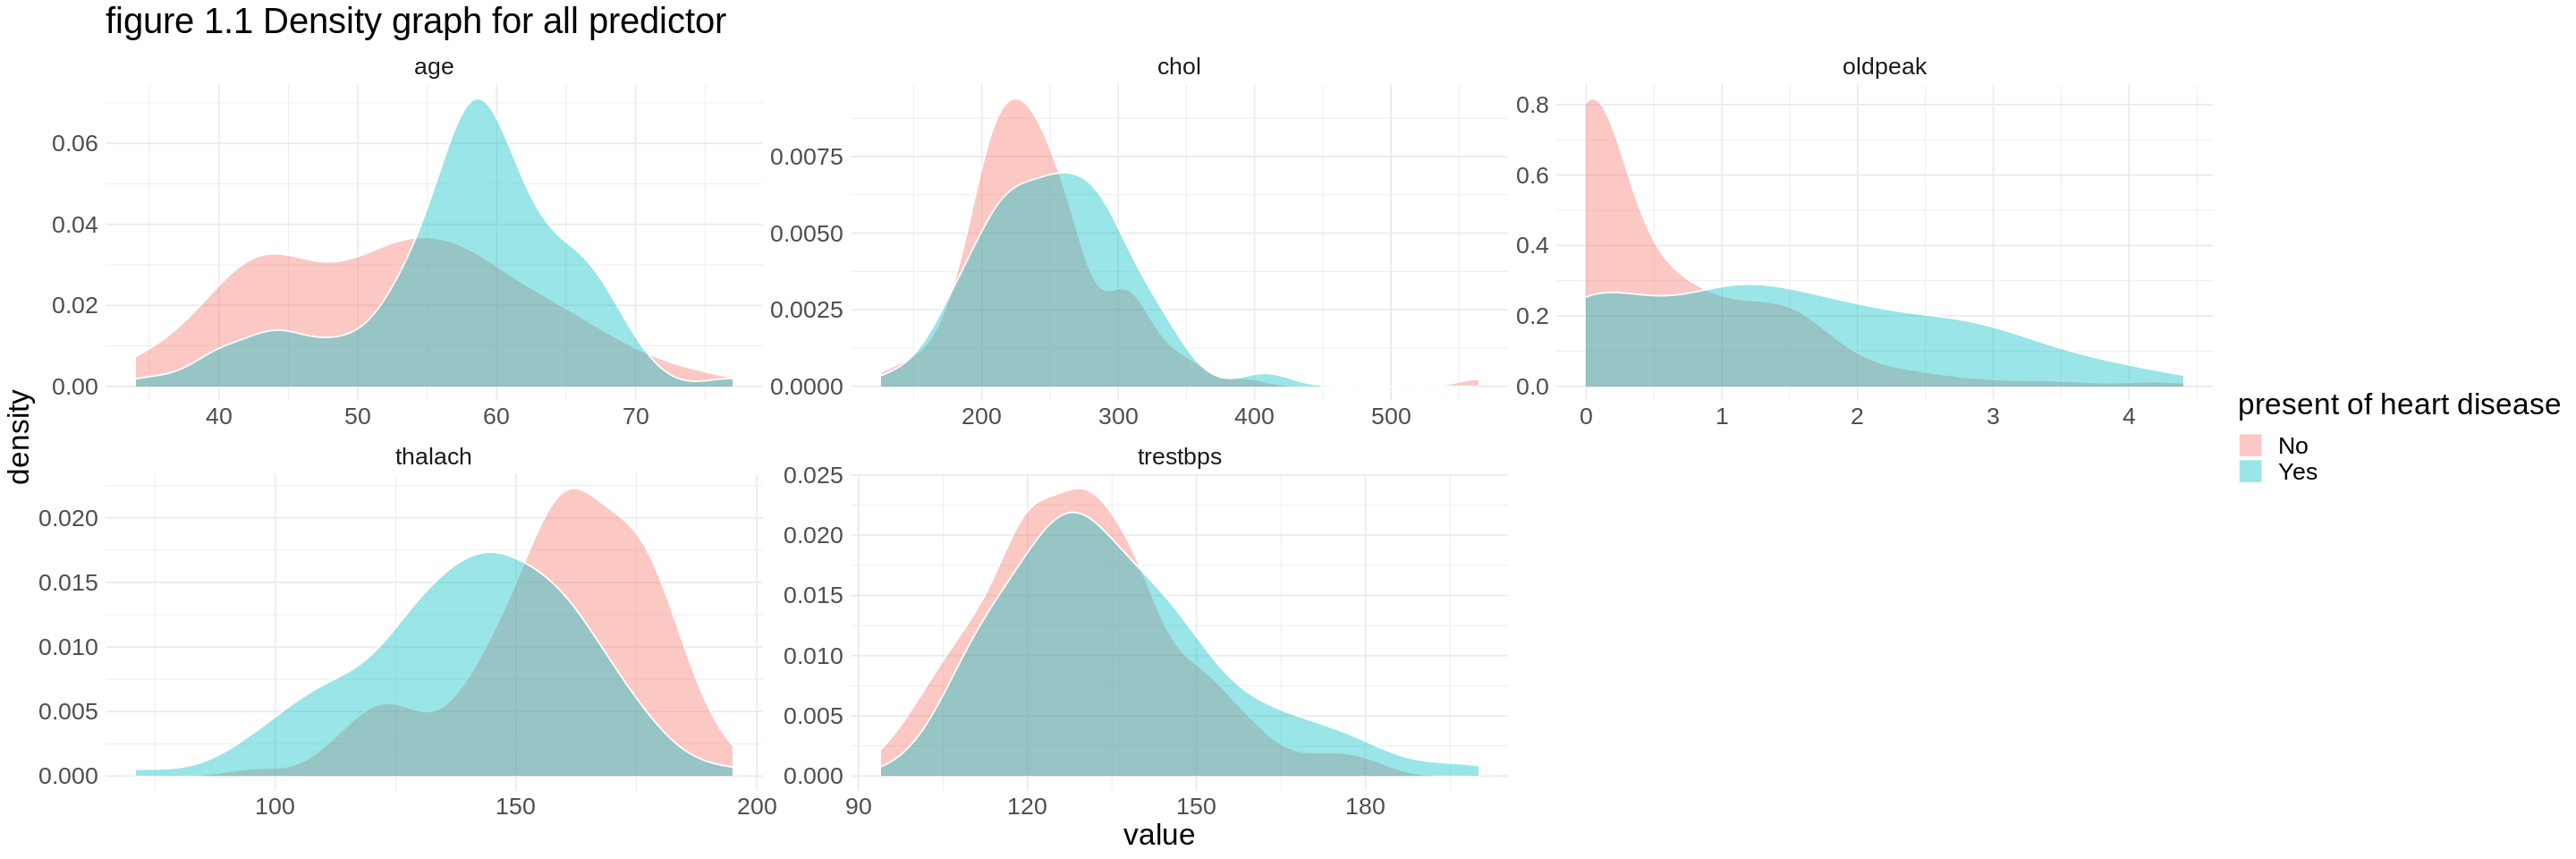

In [18]:
set.seed(2022)
cleveland_data_training_mutate= cleveland_training %>%
mutate(ca = as.numeric(ca), thal = as.numeric(thal))
cleveland_numeric <- cleveland_data_training_mutate %>% 
                     select(-sex, -cp , -fbs, -restecg, -exang, -slope, -ca, -thal) 

options(repr.plot.height = 8, repr.plot.width = 24)
cleveland_numeric %>%
    pivot_longer(cols = - num, names_to = 'category', values_to = 'value')  %>% 
    ggplot(aes(value, fill = num)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))+
scale_fill_discrete(name='present of heart disease',labels=c("No", "Yes"))+
ggtitle("figure 1.1 Density graph for all predictor ")

We first eliminated all the categorical variables, since what we learned in classification mainly focused on using numeric predictors. Moreover, even though the categorical variables in our data set seem to have numeric values, if we directly convert the categorical variables into numerical ones, we would not know what numeric values to assign. The distance between numeric values assigned to each factor would therefore have a negative impact on accuracy. 

<blockquote>
For example, cp(chest pain type) in our data set has four different categories. However, the four chest pain categories do not have a rank in strength but rather are equally different. Therefore, if we convert them to 1,2,3 and 4 respectively, then 1 would be further away from 3 compared with 2 to 3, while the categories of 1 and 2 are equally different from category 3 in reality.  





Thus, the act of converting categorical variables into numerical variables would negatively affect the accuracy of the classifier. Therefore, we deselect the following variables since they are categorical: sex, cp , fbs, restecg, exang , slope , ca , thal. 

!!! after that why we choose age and thalach from (age, chol, oldpeak,thalach and trestbps)(mention strong chracteristic, unoverlaps area)


### Training Data Summary

We have successfully chosen our exploratory variables, and now we will present a visualization of age and thalach in the training data set. Below we use histograms to show the distribution of age and thalach of the training set population; each predictor has 2 plots, one showing the predictor distribution for people who have heart disease, and one showing distribution of those who do not.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


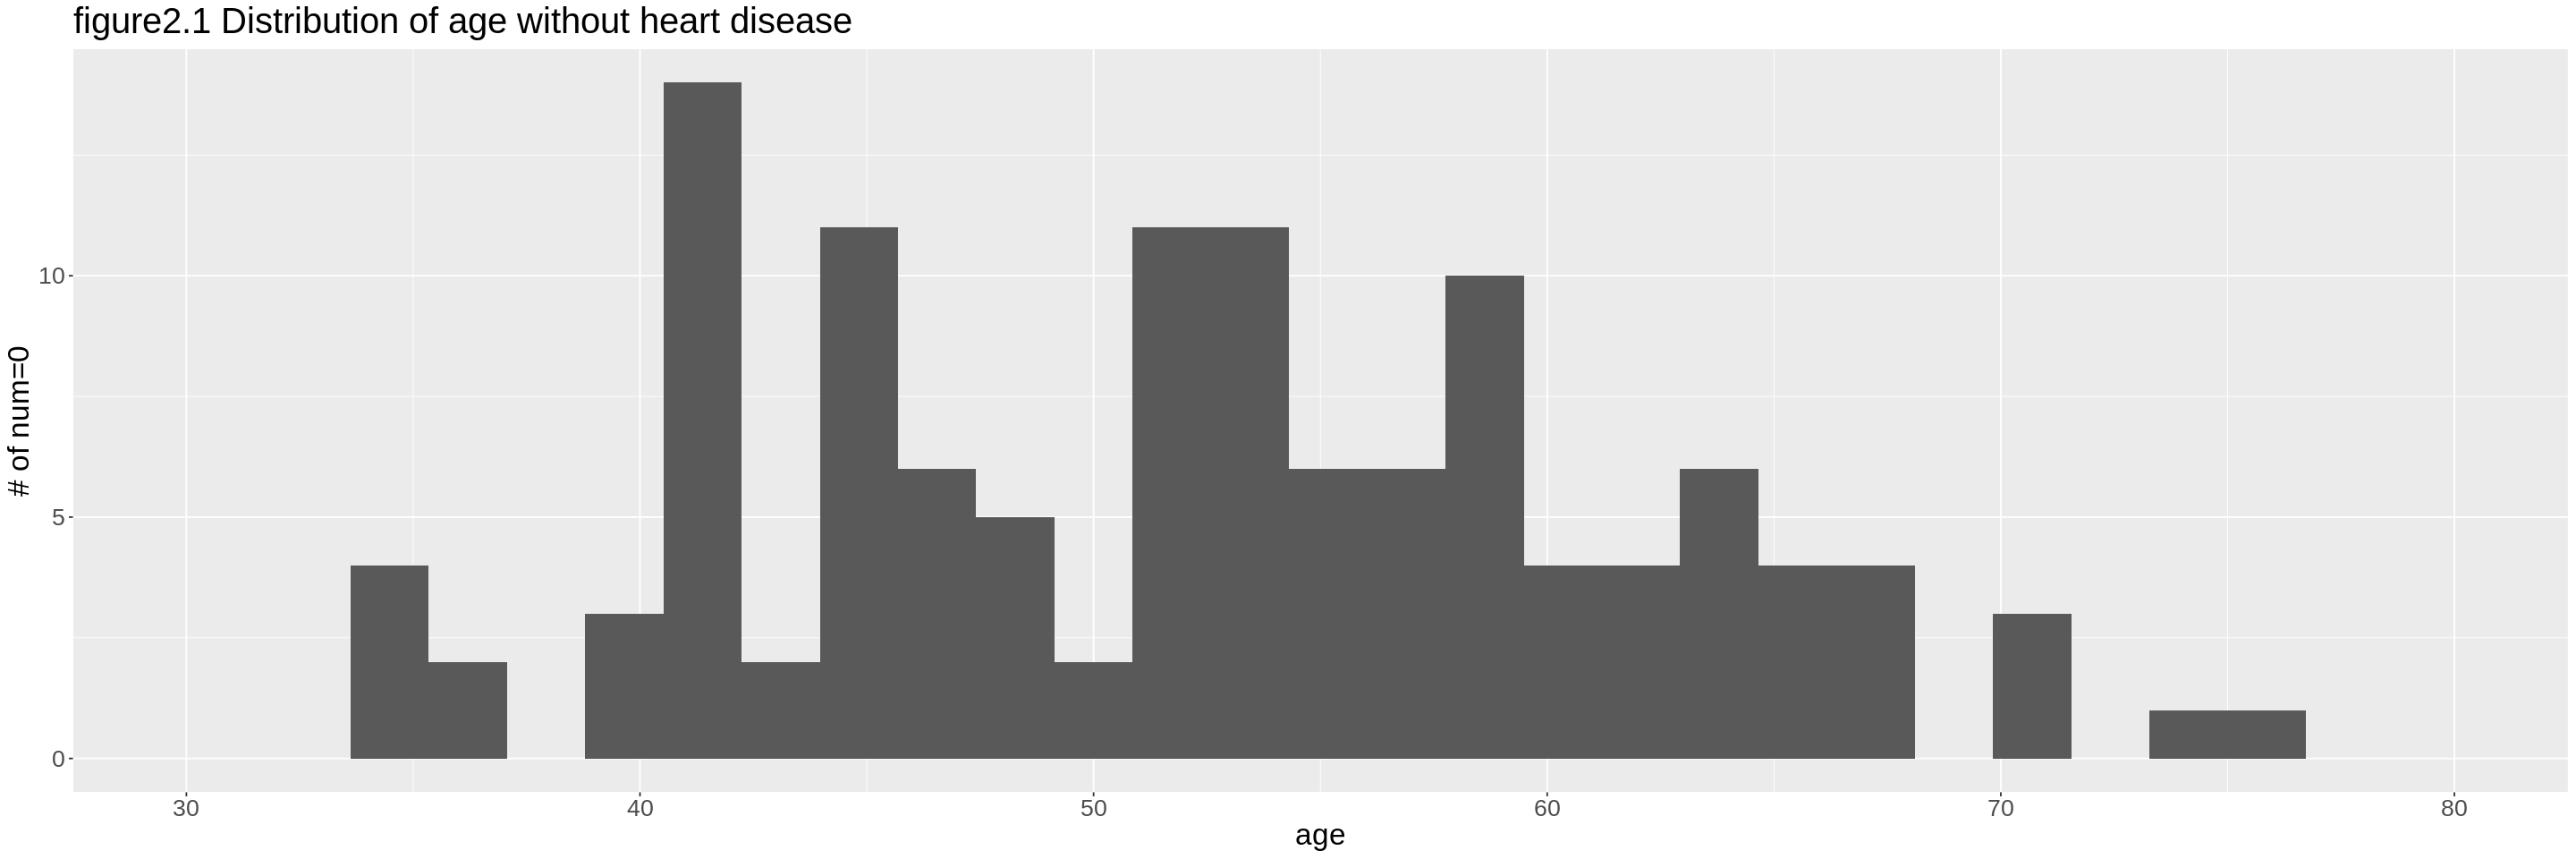

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


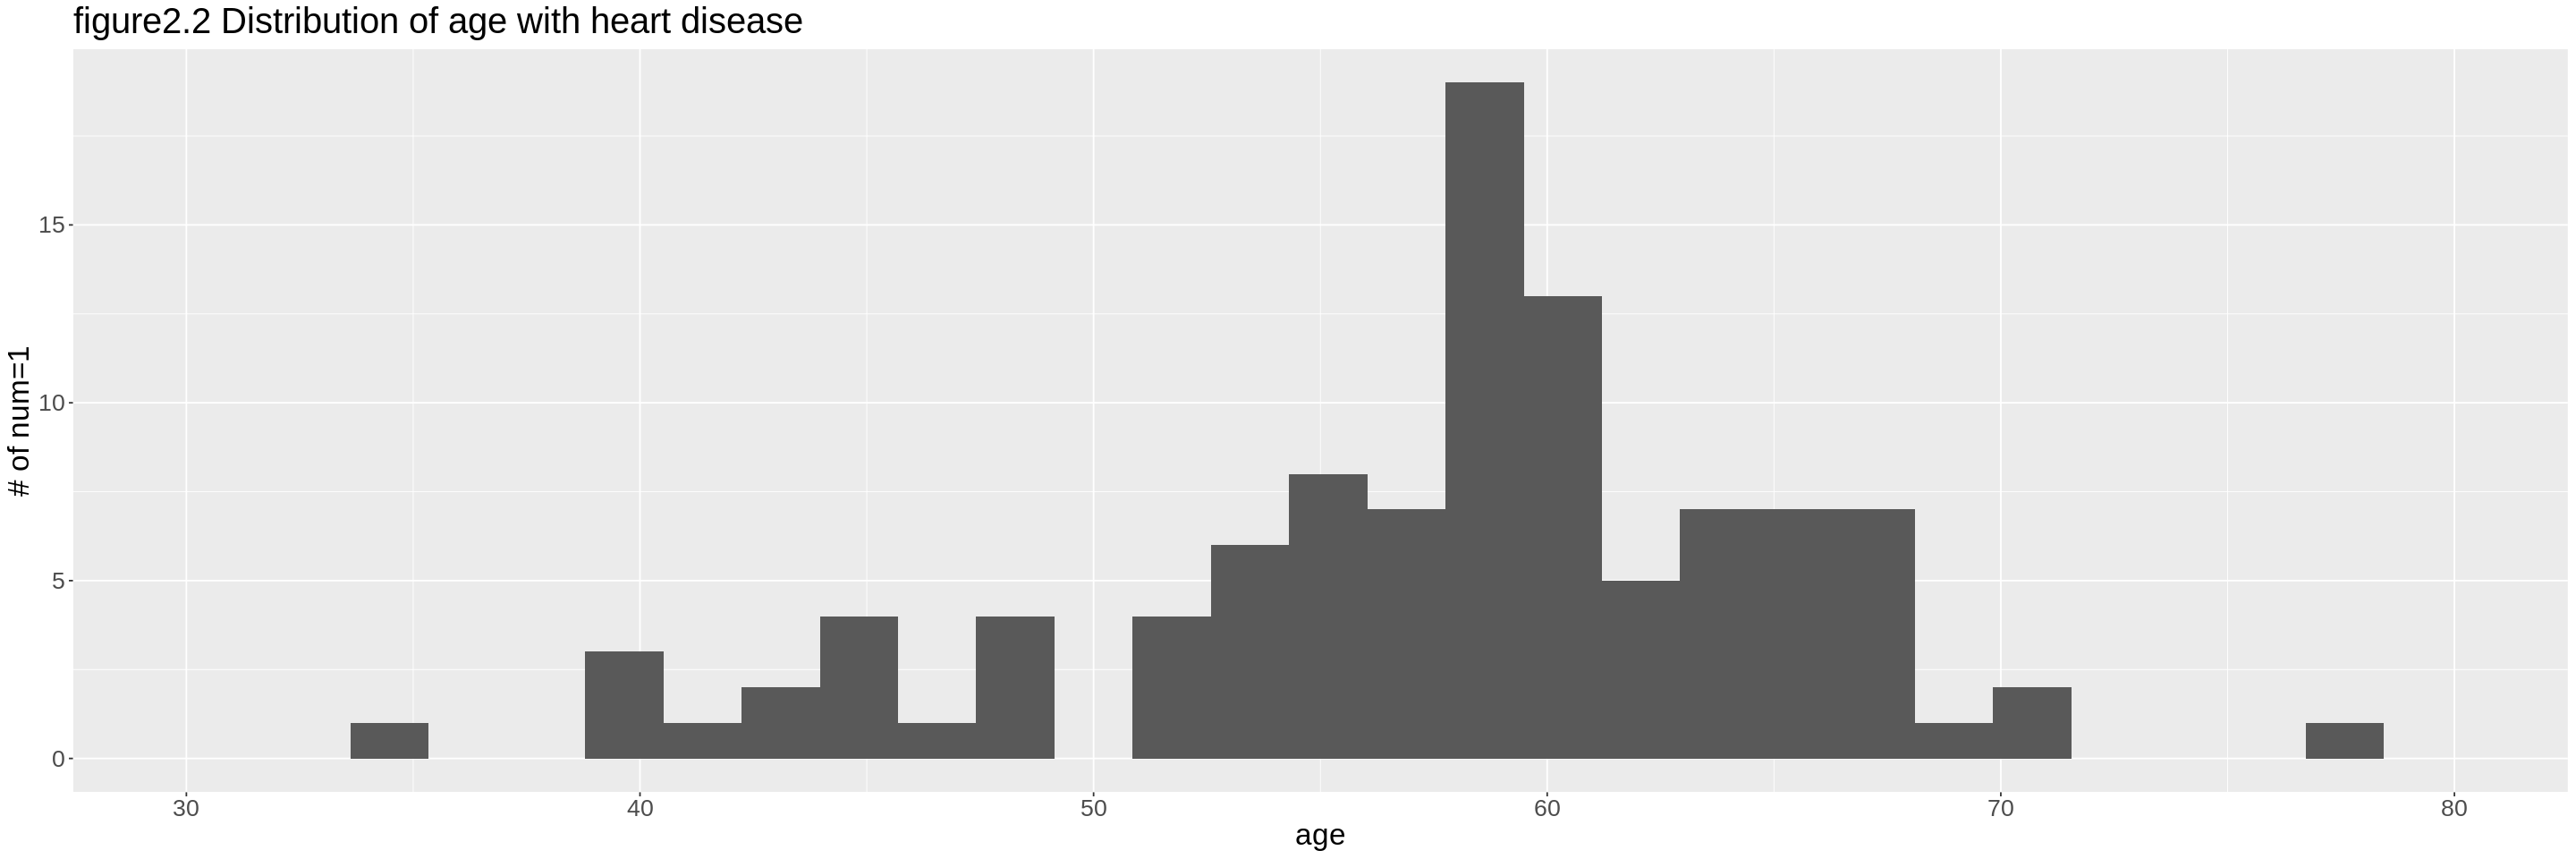

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


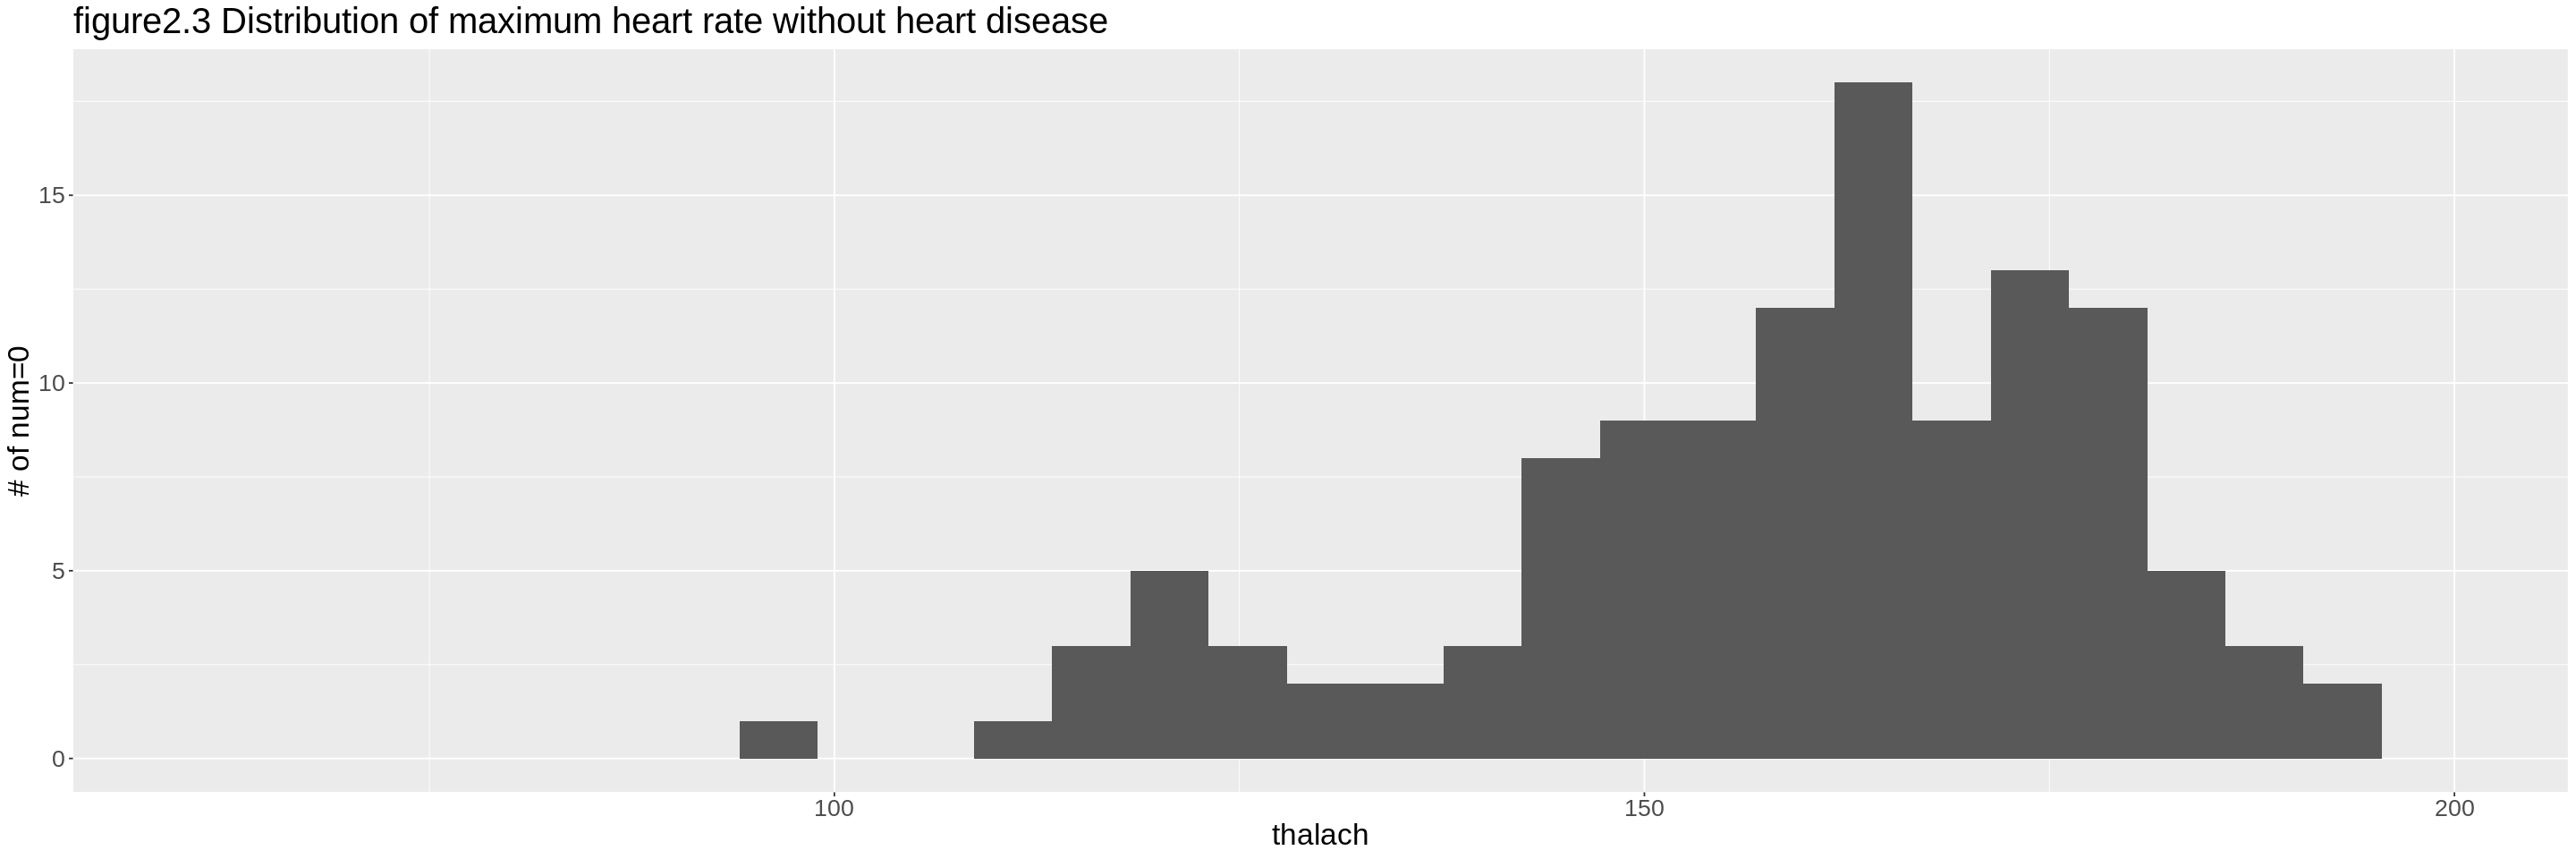

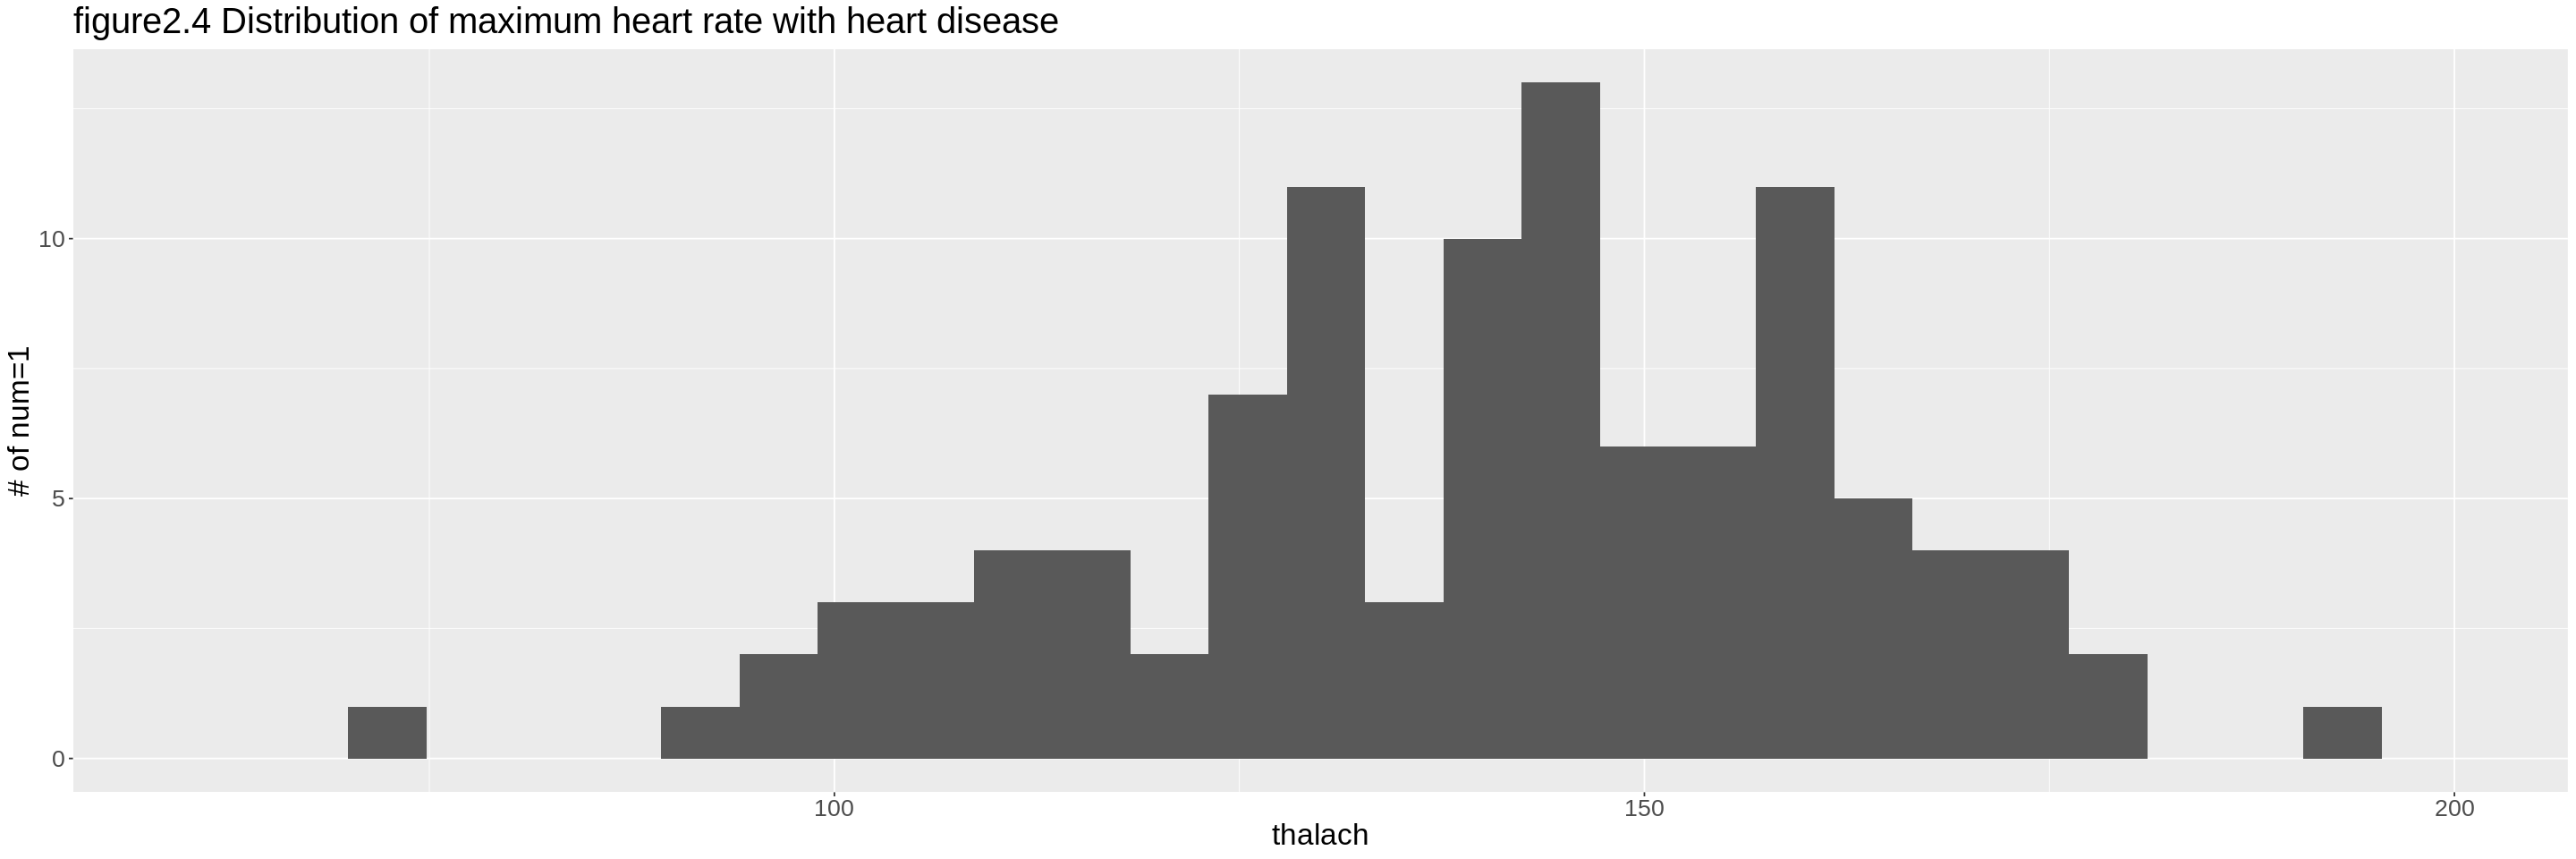

In [19]:
plot_age_0<-cleveland_training%>%
filter(num==0)%>%
ggplot(aes(x = age,)) + 
   geom_histogram() +
    labs(x= "age", y= "# of num=0")+
    theme(text = element_text(size=20))+
    ggtitle("figure2.1 Distribution of age without heart disease ")+
    xlim(c(30,80))
plot_age_0

plot_age_1<-cleveland_training%>%
filter(num==1)%>%
ggplot(aes(x = age,)) + 
   geom_histogram() +
    labs(x= "age", y= "# of num=1")+
    theme(text = element_text(size=20))+
    ggtitle("figure2.2 Distribution of age with heart disease")+
    xlim(c(30,80))
plot_age_1


plot_thalach_0<-cleveland_training%>%
filter(num==0)%>%
ggplot(aes(x = thalach,)) +
geom_histogram() +
labs(x= "thalach", y= "# of num=0")+
theme(text = element_text(size=20))+
ggtitle("figure2.3 Distribution of maximum heart rate without heart disease")+
xlim(c(60,200))
plot_thalach_0

plot_thalach_1<-cleveland_training%>%
filter(num==1)%>%
ggplot(aes(x = thalach,)) +
geom_histogram() +
labs(x= "thalach", y= "# of num=1")+
theme(text = element_text(size=20))+
ggtitle("figure2.4 Distribution of maximum heart rate with heart disease")+
xlim(c(60,200))
plot_thalach_1

Above is the distribution of the predictors we chose, but we are also interested in the mean and other statistics of the predictors. In the code cell below, we have determined the total number as well as the mean of each group (the entire training set, those with heart disease and those without heart disease) in the commented out code part. We organized the data summary in the table below:


In [10]:
#summary and mean values
set.seed(2022)

#missing values are removed in the cleaning process (6 missing values in total)

total_num<-cleveland_training %>%
group_by(num)%>%
summarize(n=n())%>%
pivot_wider(names_from = num , values_from = n)%>%
rename (without_hd = "0" ,with_hd ="1")

n_of_row<-cleveland_training %>%
summarize(n_of_row=n())

avg_total<-cleveland_training %>%
mutate (avg_age = mean(age),  
       avg_thalach = mean(thalach))%>%
select (avg_age ,avg_thalach)%>%
slice (1)

avg_nohd<-cleveland_training %>%
filter(num == 0)%>%
mutate (avg_age_nohd = mean(age),  
       avg_thalach_nohd = mean(thalach))%>%
select (avg_age_nohd ,avg_thalach_nohd)%>%
slice (1)

avg_hd <-cleveland_training %>%
filter(num == 1)%>%
mutate (avg_age_hd = mean(age),  
       avg_thalach_hd = mean(thalach))%>%
select (avg_age_hd ,avg_thalach_hd)%>%
slice (1)
# ↑where we get our value for the table 
sum_table <- bind_cols(total_num,n_of_row ,avg_total,avg_nohd,avg_hd )

sum_table

`summarise()` ungrouping output (override with `.groups` argument)



without_hd,with_hd,n_of_row,avg_age,avg_thalach,avg_age_nohd,avg_thalach_nohd,avg_age_hd,avg_thalach_hd
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
120,103,223,54.81614,150.1883,52.40833,158.6333,57.62136,140.3495


Table2.1 Number of people and their averge age , max heart rate with heart disease and without heart disease and combained.

Below is an visualization of the relationship between patients' age and thalach, and whether they have heart disease or not.

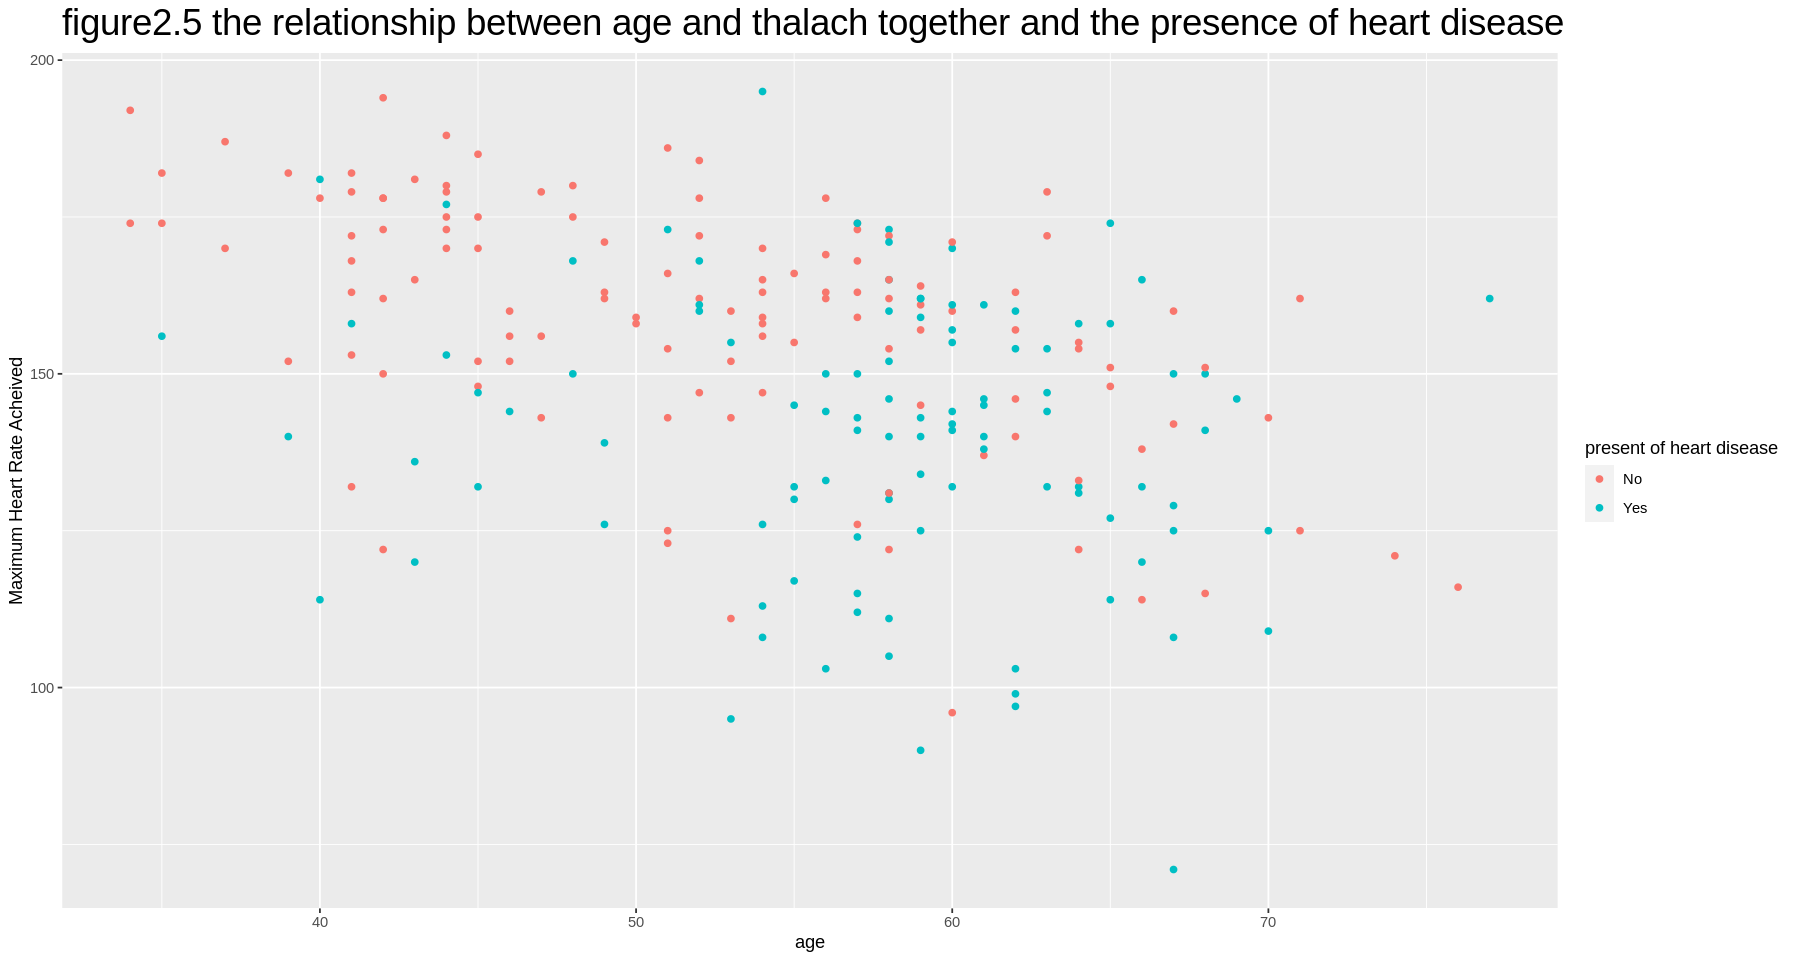

In [11]:
visuals <- cleveland_training %>% 
           ggplot(aes(x = age, y = thalach, color = num)) +
           geom_point() +
           labs(x = "age", y = "Maximum Heart Rate Acheived", color = "Presence of Heart Disease") +
           ggtitle("figure2.5 the relationship between age and thalach together and the presence of heart disease")+
           scale_color_discrete(name='present of heart disease',labels=c("No", "Yes"))+
           theme(plot.title = element_text(size=22))
visuals

!!!explaination for the scatter plot dont't clude this if we don't have a strong reason for this 

### Data analysis

We hypothesize that age and max heart rate are the most related to heart disease, so we will use the two columns “age" and “thalach”, as well as num (have(0) / don’t have heart disease(1)) in our data analysis.



We build ad train our classifier by performing the following steps:




1. We create the recipe and specified the variable to be predicted to be num and predictors to be age and max heart rate. We scaled and centered all the predictors for accurate results.
2.For stronger performance, we perform 10 v-fold on the training data.
3.We specify the knn model and set engine to kknn, mode to classification and use knn_tune to pick the best value for knn.
4.We put everything together by workflow. The recipe, model, and v-fold is put together, and we use collect_metrics to show metrics. After that, we filter only the accuracy metric to only show accuracy.
5.We plot the accuracy against the knn. Then, we could see which knn value has the highest accuracy, and pick our knn value accordingly.




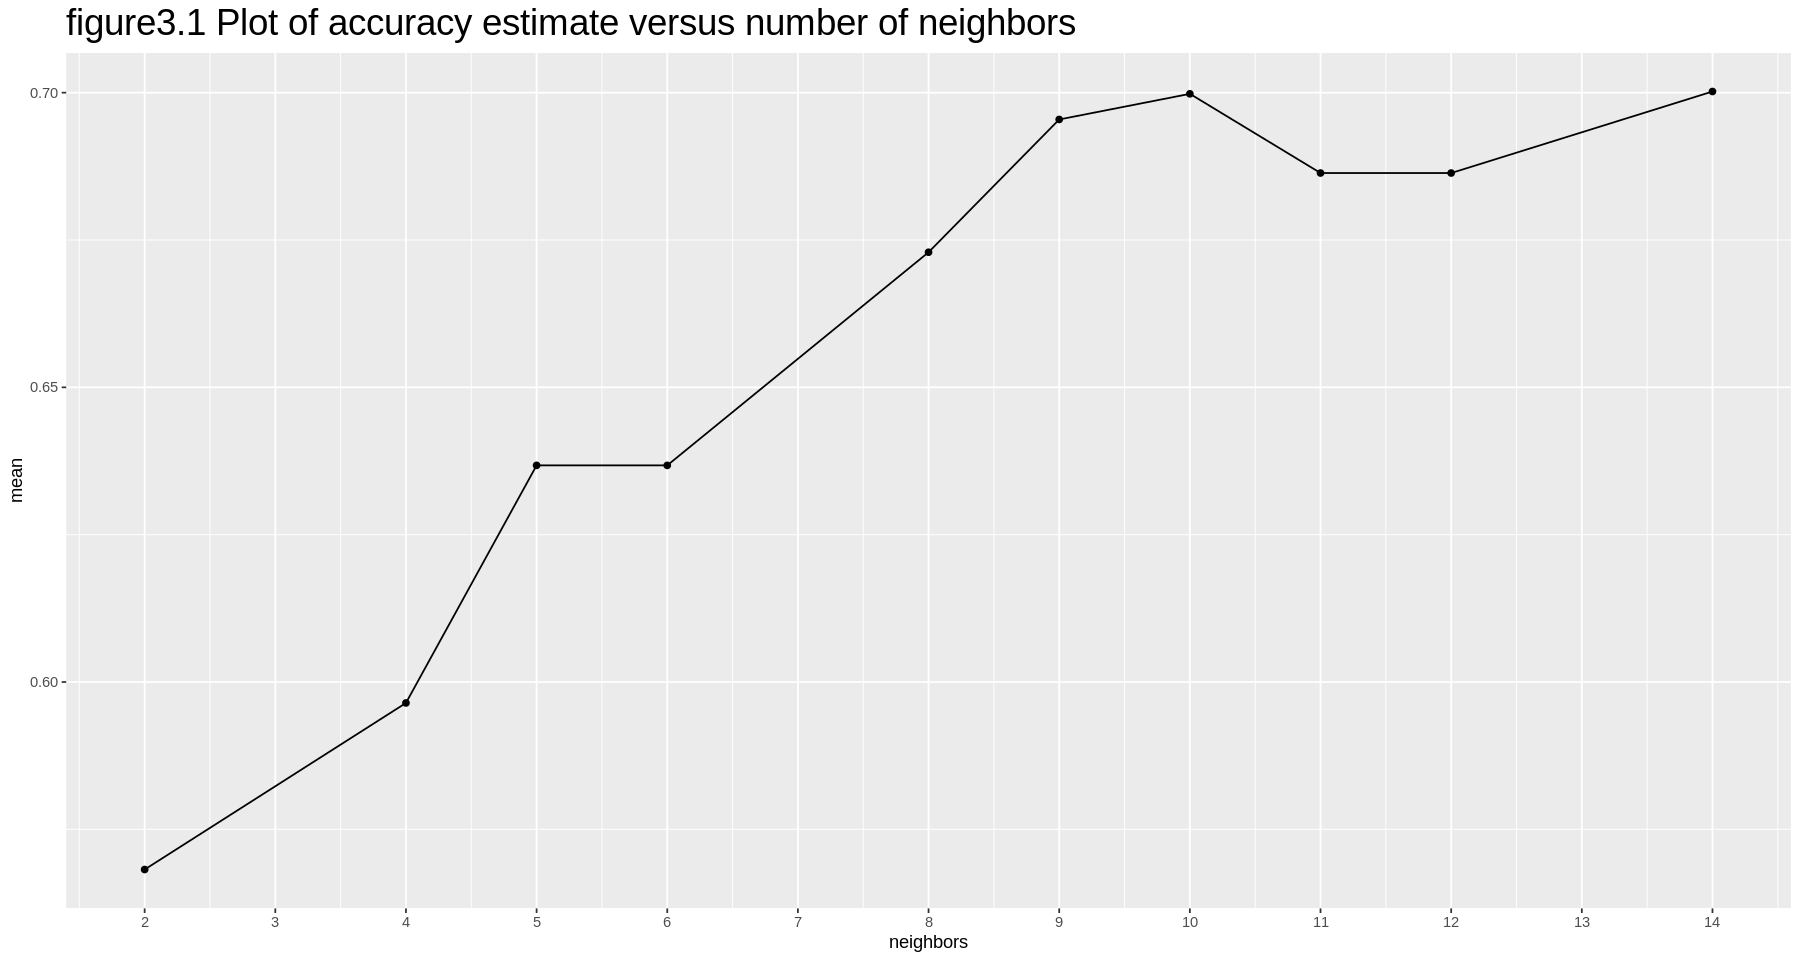

In [12]:
set.seed(2022)

vrecipe <- recipe(num~ age + thalach , data = cleveland_training)%>%
  step_scale(all_numeric()) %>%
    step_center(all_numeric())

vfold <- vfold_cv( cleveland_training, v = 10, strata = num)
knn_tune= nearest_neighbor(weight_func = "rectangular", neighbors = tune() )%>%
    set_engine("kknn")%>%
    set_mode("classification")


knn_results <- workflow() %>%
       add_recipe(vrecipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = vfold, grid = 10) %>%
       collect_metrics()

accuracies <- knn_results %>% 
        filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       ggtitle("figure3.1 Plot of accuracy estimate versus number of neighbors")+
       scale_x_continuous(breaks = c(0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15))+
       theme(plot.title = element_text(size=22))

cross_val_plot 


In [13]:
#determine the best neighbor number
best_neightbors <- accuracies%>%
arrange(neighbors)%>%
select(mean, neighbors)%>%
arrange(desc(mean))%>%
slice(1)
best_neightbors

mean,neighbors
<dbl>,<int>
0.7001976,14


table3.1 Number of neighbors with the highest accuracy.<blockquote>To prevent confusion of whether to use 10 or 14 for our best number of neighbors , we use the arrange and slice function to directly select our K value that has the highest accuracy.<blockquote>

After training our classifier, we use it to predict the testing dataset by performing the following steps:





1. We perform the recipe and knn_model steps again, and put it in the workflow, assign it to an object called mnist_fit.
2. In order to show the accuracy of our classifier, we perform a prediction on our testing dataset by passing the mnist_fit and the testing dataset to the predict function. A testing column is bound to the data output.
3. we use the metric function to show the accuracy of our classifier. 


In [14]:
set.seed(2022)

cleveland_recipe <- recipe(num ~age  + thalach , data = cleveland_training)%>%
  step_scale(all_predictors()) %>%
    step_center(all_predictors())


mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors =14) %>%
    set_engine("kknn") %>%
    set_mode("classification")

mnist_fit <- workflow() %>%
        add_recipe(cleveland_recipe)%>%
        add_model(mnist_spec) %>%
        fit(data = cleveland_training)

mnist_predictions <- predict (mnist_fit, cleveland_testing) %>%
    bind_cols(cleveland_testing)

mnist_metrics <- mnist_predictions %>%
    metrics(truth = num, estimate = .pred_class)%>%
filter(.metric == "accuracy")
mnist_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7162162


table3.2 accuracy of our classifier is 71.6%

In [15]:
confusion <- mnist_predictions %>% 
             conf_mat(truth = num, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 28  9
         1 12 25

!!! explaination for this

# Discussion

!!! Add explanations , ALOT OF EXPLAINATION 😭 

check list 
* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?



After the training and testing, we found our classifier to be  71.6% accurate. 


We found a positive relationship between age and the presence of heart disease, and a negative relationship between maximum heart rate and heart disease.  


# Citation

#### Reference artical

Piga, A., 2008. High nontransferrin bound iron levels and heart disease in thalassemia major.
[online] Wiley online library. Available at: https://onlinelibrary.wiley.com/doi/abs/10.1002/ajh.21317 [Accessed 5 April 2022].

Chen, A., 2022. HDPS: Heart disease prediction system.
[online] Ieeexplore.ieee.org. Available at: https://ieeexplore.ieee.org/abstract/document/6164626 [Accessed 5 April 2022].

Huikuri, H. V., &amp; Mäkikallio, T. H. (2001, June 12). Heart rate variability in ischemic heart disease. Autonomic Neuroscience. Retrieved April 7, 2022, from https://www.sciencedirect.com/science/article/pii/S1566070201002739


#### Data source
W. Aha, D., 2022. UCI Machine Learning Repository: Heart Disease Data Set.
[online] Archive.ics.uci.edu. Available at: https://archive.ics.uci.edu/ml/datasets/Heart+Disease [Accessed 6 April 2022].
